In [1]:
from dask import delayed

Notes
- `dask delayed` gives flexibility when other abstractions such as dask dataframes, arrays or numpy arrays are not suitable 
- because `dask delayed` uses threads by default, applying it to a function that does not cirvumvent the GIL will not give much speed-up. But applying it for instance to a compiled function (with numba) can make things much faster.
- in particular, `dask delayed` can sometimes be useful to build complex computational workflows 

In [27]:
# copying pi from previous episode 
import random

def calc_pi(N):
    M = 0
    for i in range(N):
        # Simulate impact coordinates
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)

        # True if impact happens inside the circle
        if x**2 + y**2 < 1.0:
            M += 1
    return 4 * M / N



In [2]:
@delayed
def add(a, b):
    result = a + b
    print(f"{a} + {b} = {result}")
    return a + b

In [6]:
x_p = add(3, 4)

In [7]:
type(x_p)

dask.delayed.Delayed

In [8]:
x_p.compute()

3 + 4 = 7


7

In [9]:
type(x_p)

dask.delayed.Delayed

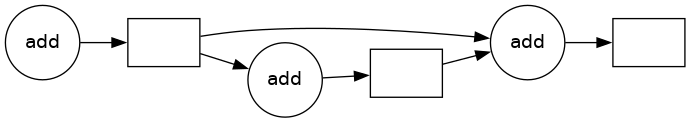

In [15]:
x_p = add(1, 2)
y_p = add(x_p, 3)
z_p = add(x_p, y_p)
z_p.visualize(rankdir="LR")

Challenge: running the workflow

In [16]:
x_p = add(1, 2)
y_p = add(x_p, 3)
z_p = add(x_p, -3)

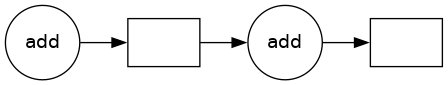

In [21]:
y_p.visualize(rankdir="LR")


In [24]:
y_p.compute()

1 + 2 = 3
3 + 3 = 6


6

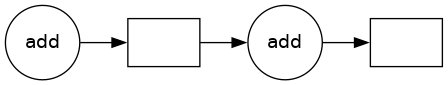

In [19]:
z_p.visualize(rankdir="LR")

In [25]:
z_p.compute()

1 + 2 = 3
3 + 3 = 6
3 + 6 = 9


9

`x_p` is evaluated twice(?)

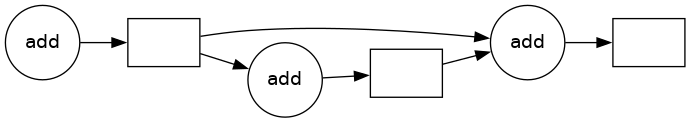

In [22]:
x_p = add(1, 2)
y_p = add(x_p, 3)
z_p = add(x_p, y_p)
z_p.visualize(rankdir="LR")

In [23]:
z_p.compute()

1 + 2 = 3
3 + 3 = 6
3 + 6 = 9


9

`x_p` is evaluated once.

In [28]:
N = 10**7
x_p = delayed(calc_pi)(N)

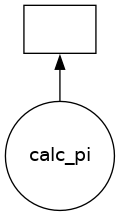

In [29]:
x_p.visualize()

In [30]:
x_p.compute()

3.1422684

In [31]:
@delayed
def gather(*args):
    return list(args)

what does `gather` above do?
- equivalent to `delayed(gather)(*args)`
- creates a list of promises, which can then be evaluated all at the same time with `compute()`?
- "turns a list of promises into a promise of a list": upon calling `compute`, the gathered arguments are computed and a list of their outputs is returned?
- -- see below

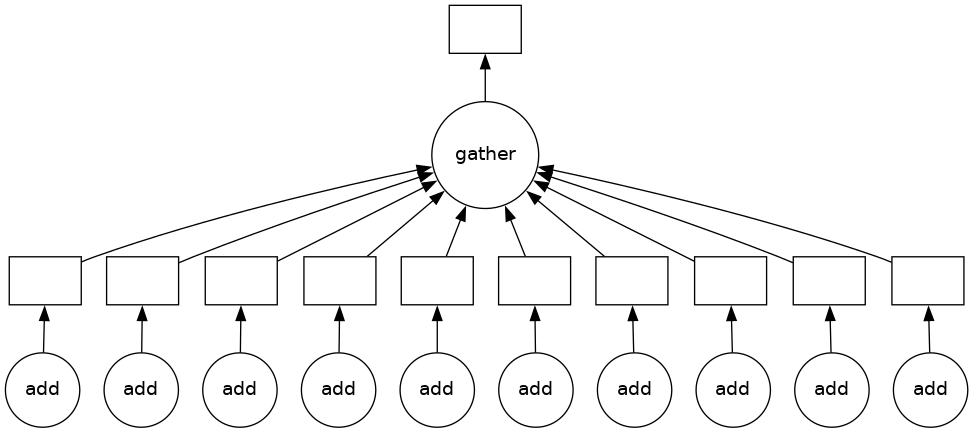

In [32]:
x_p = gather(*(add(n, n) for n in range(10))) # Shorthand for gather(add(1, 1), add(2, 2), ...)
x_p.visualize()

In [33]:
x_p.compute()

9 + 9 = 18
0 + 0 = 0
4 + 4 = 8
5 + 5 = 10
2 + 2 = 4
3 + 3 = 6
7 + 7 = 14
1 + 1 = 2
8 + 8 = 16
6 + 6 = 12


[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

Challenge: design a `mean` function and calculate $\pi$

In [70]:
import numba 

@delayed

def mean(*args):
    # old approach:
    # lst = list(args) # <-- works
    # lst = gather(args) # <-- does not work. why?
    # return sum(lst) / len(lst)
    return sum(args) / len(args)



@delayed
# @numba.jit(nopython=True, nogil=True) # <-- using this makes a huge difference.
def calc_pi_delayed(N):
    M = 0
    for i in range(N):
        # Simulate impact coordinates
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)

        # True if impact happens inside the circle
        if x**2 + y**2 < 1.0:
            M += 1
    return 4 * M / N



In [71]:
n_threads = 10
N = 10**7

pi = mean(*(calc_pi_delayed(int(N / n_threads)) for _ in range(n_threads)))


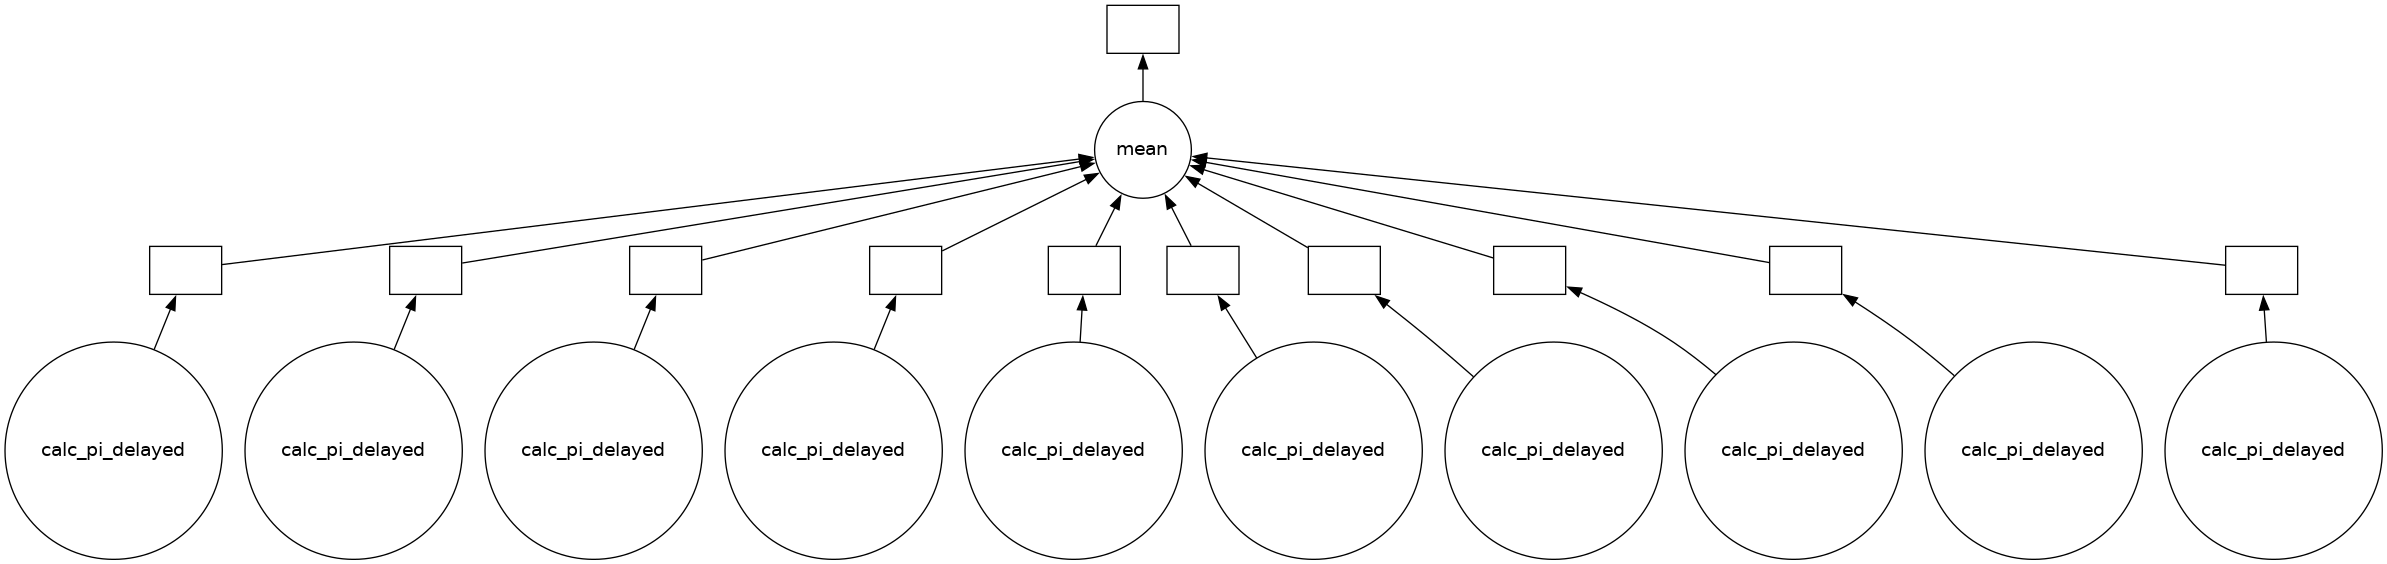

In [72]:
pi.visualize()

In [73]:
pi.compute()

3.1429132